In [1]:
using Revise, Plots, LinearAlgebra, LaTeXStrings, Random, Distributions, Images

In [2]:
includet("../../src/SparseSpikes.jl")
using .SparseSpikes

Define ground truth amplitudes and positions

In [3]:
domain = [[0, 1], [0, 1]]

2-element Vector{Vector{Int64}}:
 [0, 1]
 [0, 1]

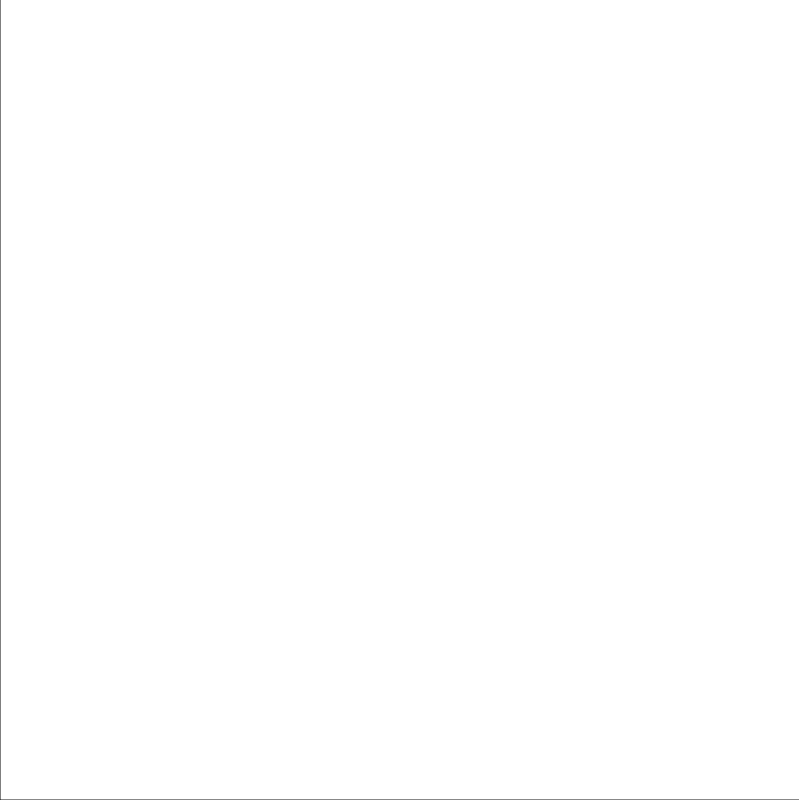

In [72]:
# Define the plot
num_points = 64

plt_grid_x1 = [domain[1][1] + i * (domain[1][2] - domain[1][1]) / (num_points - 1) for j in 0:num_points-1, i in 0:num_points-1]
plt_grid_x2 = [domain[2][1] + j * (domain[2][2] - domain[2][1]) / (num_points - 1) for j in 0:num_points-1, i in 0:num_points-1]

grid = range(0, stop=1, length=num_points)
plot_size = (400, 400) .* 2
using Plots.Measures
plt = heatmap(xlims=domain[1], ylims=domain[2], color=:viridis, colorbar=:none, size=plot_size, grid=false, ticks=:none, margins=-2mm)

# plt_gt = deepcopy(plt)
# plot_spikes!(plt_gt, μ0, label=L"μ_0", colorscheme=:viridis)

## Check $\sigma$ parameter

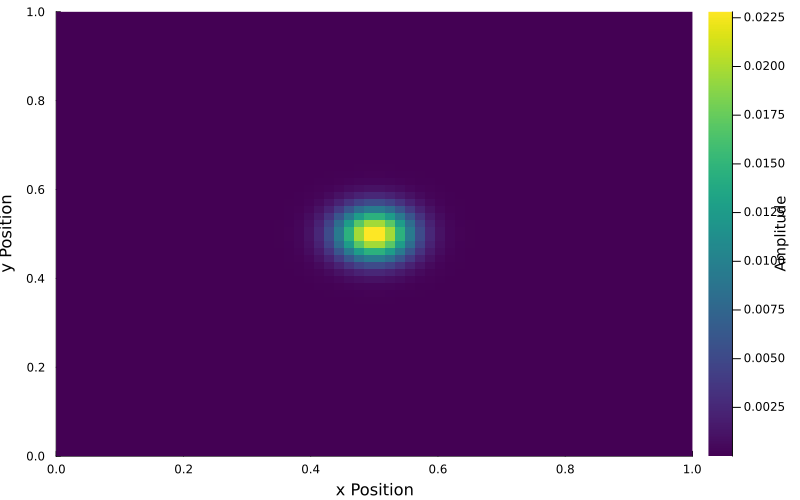

In [31]:
# const noise_mean = 0.0021172377176794793
const σ2 = let
    λ = 723.0 # Wavelength
    NA = 1.4 # Numerical aperture
    FWHM = λ / (2 * NA) # Full width at half maximum i.e. diffraction limit
    σ = FWHM / (2 * log(2.0))
    (σ / (64 * 100.0))^2
end
σ = sqrt(σ2)

ops = gaussian_operators_2D(σ, plt_grid_x1, plt_grid_x2)

plt_test_σ = deepcopy(plt)
heatmap!(plt_test_σ, grid, grid, ops.adjΦ(ops.Φ([0.5], [0.5], [1.0])), color=:viridis)

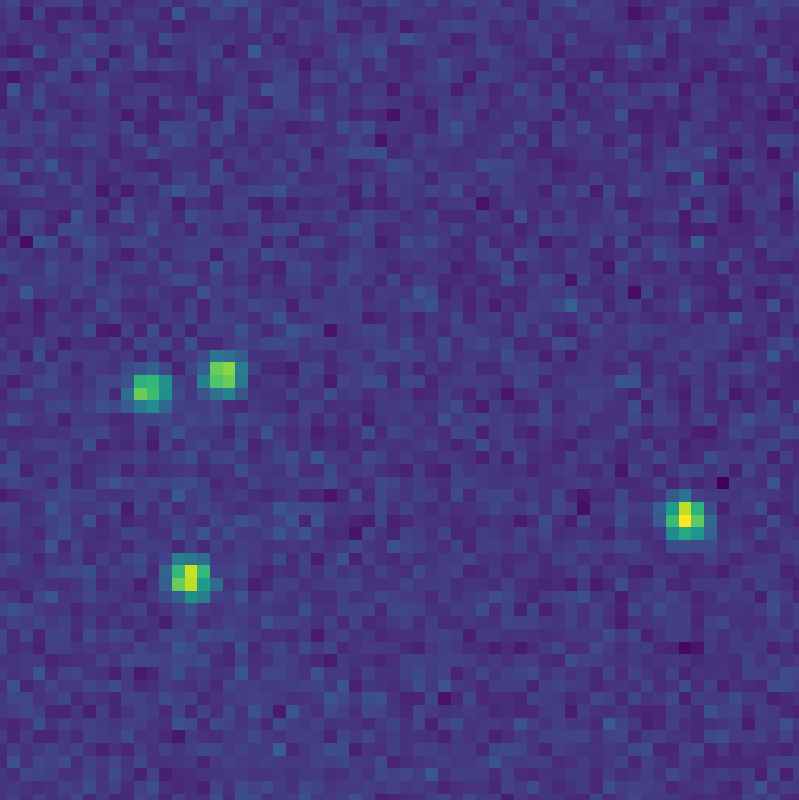

In [74]:
plt_obs = deepcopy(plt)

image = load("../../low_density/sequence/00001.tif")

y = channelview(image)
heatmap!(plt_obs, grid, grid, y, label="y_0", color=:viridis)

### SFW

In [35]:
λ = 0.0026#32 # Regularisation parameter
# λ = 0.032

prob = BLASSO(vec(y), ops, domain, λ)

BLASSO(N0f16[0.00208N0f16, 0.00204N0f16, 0.00212N0f16, 0.00185N0f16, 0.00194N0f16, 0.00221N0f16, 0.00197N0f16, 0.00214N0f16, 0.00215N0f16, 0.00198N0f16  …  0.00211N0f16, 0.00163N0f16, 0.00186N0f16, 0.002N0f16, 0.00163N0f16, 0.00188N0f16, 0.00198N0f16, 0.00186N0f16, 0.00203N0f16, 0.00232N0f16], Operators(var"#ϕ#201"{Int64}(Core.Box(var"#gauss2D#200"{Matrix{Float64}, Float64}(Core.Box(#= circular reference @-2 =#), [0.0 0.0; 0.0 0.015873015873015872; … ; 1.0 0.9841269841269841; 1.0 1.0], 590.3102629802514)), 4096), var"#Φ#202"{var"#ϕ#201"{Int64}, Int64}(var"#ϕ#201"{Int64}(Core.Box(var"#gauss2D#200"{Matrix{Float64}, Float64}(Core.Box(#= circular reference @-2 =#), [0.0 0.0; 0.0 0.015873015873015872; … ; 1.0 0.9841269841269841; 1.0 1.0], 590.3102629802514)), 4096), Core.Box(var"#gauss2D#200"{Matrix{Float64}, Float64}(Core.Box(#= circular reference @-2 =#), [0.0 0.0; 0.0 0.015873015873015872; … ; 1.0 0.9841269841269841; 1.0 1.0], 590.3102629802514)), 4096), var"#adjΦ#207"{Matrix{Float64}, M

In [38]:
solve!(prob, :SFW, options=Dict(:maxits => 10))

prob.μ

SFW iterations: 100%|███████████████████████████████████| Time: 0:00:00


DiscreteMeasure([[0.8581943695274071, 0.23760760894294639, 0.18777708303901414, 0.2790954917253064], [0.3516367204951154, 0.276996894620114, 0.5116563863575608, 0.5313747789508905]], [0.029069323677955367, 0.028514343847501872, 0.017654198762102002, 0.020109219763253097], 2, 4)

In [46]:
maximum(y)

0.00667N0f16

In [49]:
(prob.μ.a)

4-element Vector{Float64}:
 0.006668192568856336
 0.006540886119545939
 0.004049684756987832
 0.0046128403700190545

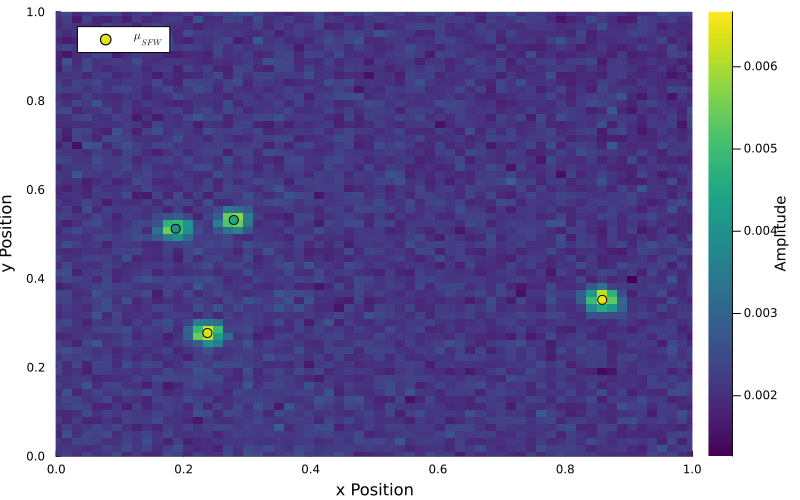

In [50]:
plt_sfw = deepcopy(plt_obs)

prob.μ.a .*= 0.97maximum(y) ./ maximum(prob.μ.a)

plot_spikes!(plt_sfw, prob.μ, label=L"μ_{SFW}", colorscheme=:viridis, marker=:circle, markersize=5, markerstrokewidth=1)

## Random frame

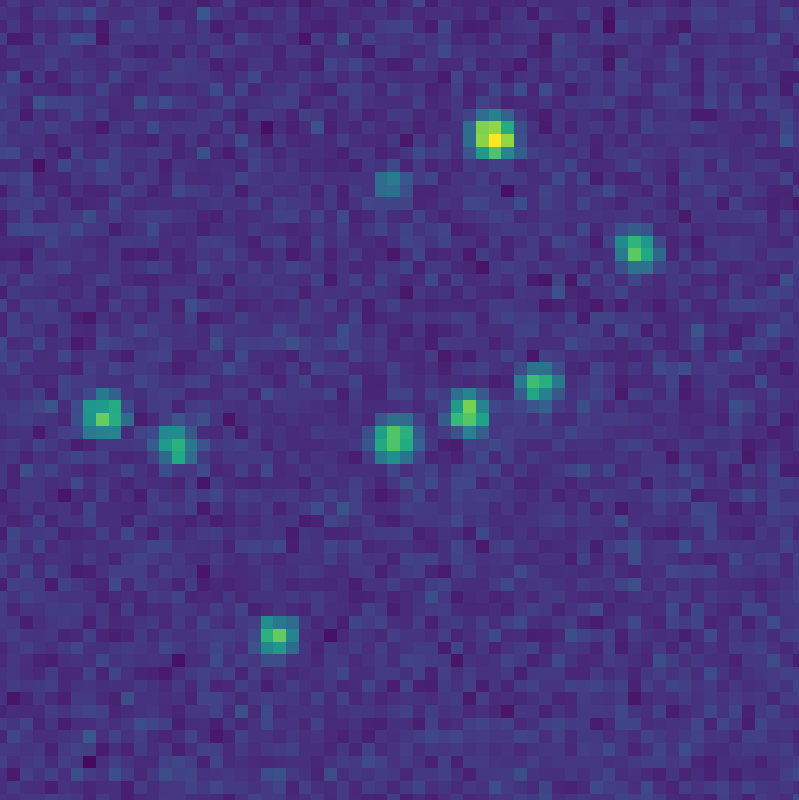

In [75]:
image = load("../../low_density/sequence/03462.tif")

y = channelview(image)
heatmap!(plt_obs, grid, grid, y, label="y_0", color=:viridis)

In [52]:
prob = BLASSO(vec(y), ops, domain, λ)
solve!(prob, :SFW, options=Dict(:descent => :BFGS, :maxits => 10))

prob.μ

SFW iterations: 100%|███████████████████████████████████| Time: 0:00:09


DiscreteMeasure([[0.6170583375782399, 0.5887855399046006, 0.7967458736840844, 0.3437686091490987, 0.12945253886733518, 0.22073069519695748, 0.6757341813699608, 0.49390223335283745], [0.8294936557024675, 0.4836636324563814, 0.6876054142085654, 0.20383002296815264, 0.48134959485870776, 0.44494390163429853, 0.5186141580812239, 0.45007362057684147]], [0.043759114700583794, 0.020611794519058667, 0.015979113797193384, 0.013770255266599592, 0.02235087593758557, 0.011696126565714775, 0.012561305751363265, 0.02504419235527173], 2, 8)

In [54]:
maximum(y)

0.0072N0f16

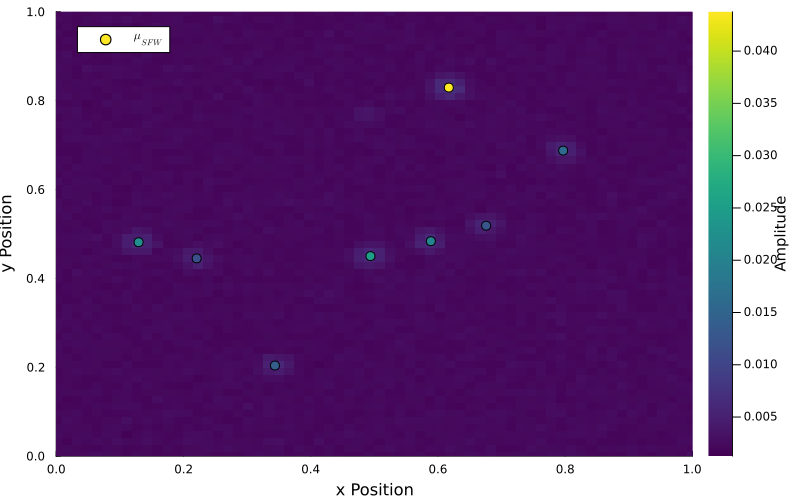

In [ ]:
plt_sfw = deepcopy(plt_obs)

plot_spikes!(plt_sfw, prob.μ, label=L"μ_{SFW}", colorscheme=:viridis, marker=:circle, markersize=5, markerstrokewidth=1)

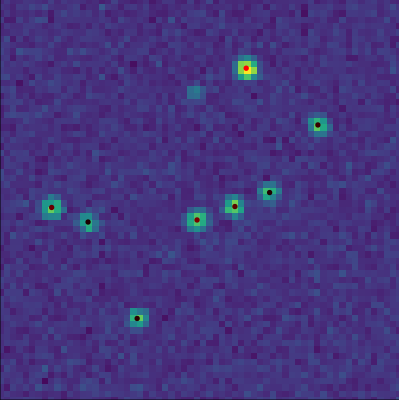

In [76]:
plt_sfw = deepcopy(plt_obs)

red_cmap = cgrad([RGB(0, 0, 0), RGB(1, 0, 0)])

prob.μ.a .*= maximum(y) ./ maximum(prob.μ.a)

scatter!(plt_sfw,
    inset=(bbox(0, 0, 1, 1, :bottom)), bgcolor=:transparent,
    prob.μ.x...,
    zcolor=prob.μ.a,
    color=red_cmap,
    legend=:none, grid=false, ticks=:none, ratio=:equal, cb=:none, size=(400,400),
    marker=:circle,
    markersize=3, markerstrokewidth=0)

In [77]:
savefig(plt_sfw, "SMLM_typical_frame_low_density.svg")

"c:\\Users\\ladis\\OneDrive - University of Warwick\\Year 4\\Super resolution\\Codes\\SparseSpikes\\examples\\SMLM\\SMLM_typical_frame_low_density.svg"